# Circuits dataset generation functions

> Functions to create a quantum circuit dataset.

In [1]:
#| default_exp platform.circuits_generation

In [2]:
#| export
from genQC.imports import *
from genQC.platform.backends.base_backend import BaseBackend
from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer, Vocabulary
from genQC.dataset.dataset_helper import get_unique_elements_indices
from genQC.utils.async_fn import MemoryMappedArray, Parallel, delayed

## Generate random circuits

In [3]:
#| export
class CircuitConditionType(enum.Enum):   
    SRV      = enum.auto() 
    UNITARY  = enum.auto() 

In [4]:
#| export
def get_rnd_encoded_circuit(backend: BaseBackend, 
                            tokenizer: CircuitTokenizer,
                            condition: CircuitConditionType,
                            num_of_qubits: int, 
                            gate_pool: Optional[Sequence[str]],
                            min_gates: int, 
                            max_gates: int,  
                            rng: np.random.Generator, 
                            optimized: bool = True,
                            post_randomize_params: bool = True,
                            return_params: bool = True) -> Tuple[Any, torch.Tensor, ...]:   
    """Generate a random circuit with corresponding condition."""

    gate_pool = default(gate_pool, tokenizer.vocabulary)

    qc = backend.rnd_circuit(num_of_qubits, rng.integers(min_gates, max_gates+1), gate_pool, rng)  
    
    if optimized:          
        qc = backend.optimize_circuit(qc, gate_pool)   
        
    if post_randomize_params: 
        qc = backend.randomize_params(qc, rng)   
    
    match condition:
        case CircuitConditionType.SRV:     
            condition = torch.tensor(backend.schmidt_rank_vector(qc))
            
        case CircuitConditionType.UNITARY: 
            U         = backend.get_unitary(qc)   
            U_r, U_i  = torch.from_numpy(np.real(U)), torch.from_numpy(np.imag(U))
            condition = torch.stack([U_r, U_i], dim=0)
    
        case _: raise NotImplementedError(f"Not implemented given condition: {condition}")
    
    instructions = backend.backend_to_genqc(qc)
    enc_tuple    = tokenizer.encode(instructions, max_gates, return_params_tensor=return_params)  # qc_tensor, params_tensor

    return qc, condition, *enc_tuple

In [5]:
#| export
def get_rnd_encoded_circuits(backend: BaseBackend, 
                             tokenizer: CircuitTokenizer,
                             condition: CircuitConditionType,                                  
                             samples: int, 
                             num_of_qubits: int, 
                             min_gates: int, 
                             max_gates: int,                       
                             min_sub_gate_pool_cnt: int = 1,
                             max_sub_gate_pool_cnt: Optional[int] = None,
                             fixed_sub_gate_pool: Optional[Sequence[str]] = None,
                             max_num_params: Optional[int] = None,
                             filter_unique: bool = True,
                             optimized: bool = True,                                                         
                             post_randomize_params: bool = True,
                             return_params: bool = True,
                             silent: bool = False) -> Tuple[torch.Tensor, ...]:
    """
    Generate ´samples´ number of random circuits with corresponding condition. 
    Creates prompts for conditioning.
    """

    if condition not in [CircuitConditionType.SRV, CircuitConditionType.UNITARY]:
        raise NotImplementedError(f"Not implemented {condition}")
    
    sub_gate_pool = fixed_sub_gate_pool
    gate_pool     = list(tokenizer.vocabulary)

    rng     = np.random.default_rng() 
    n       = len(gate_pool) + 1
    c_range = np.arange(n-1)

    if exists(max_sub_gate_pool_cnt):
        max_sub_gate_pool_cnt = max(min_sub_gate_pool_cnt, min(max_sub_gate_pool_cnt+1, n))
    else:                             
        max_sub_gate_pool_cnt = n

    #------------------
    # Generate single circuits sequentially
    
    x = []
    y = []    
    
    if condition is CircuitConditionType.UNITARY: 
        u = []
    
    if return_params: 
        p = []   # Note: params is of different size -> keep list

    for i in tqdm(range(samples), disable=silent):

        if not exists(fixed_sub_gate_pool):    
            sub_gate_pool_cnt = rng.integers(min_sub_gate_pool_cnt, max_sub_gate_pool_cnt)        
            sub_gate_pool_ind = rng.choice(c_range, size=sub_gate_pool_cnt, replace=False)   

            #NOTE: with this we have always the same ordering of the prompt gates!!
            sub_gate_pool_ind = np.sort(sub_gate_pool_ind)  
            
            sub_gate_pool     = [gate_pool[ind] for ind in sub_gate_pool_ind]

        val = get_rnd_encoded_circuit(backend=backend,
                                      tokenizer=tokenizer,
                                      condition=condition,
                                      num_of_qubits=num_of_qubits,
                                      gate_pool=sub_gate_pool, 
                                      min_gates=min_gates, 
                                      max_gates=max_gates,
                                      rng=rng,
                                      optimized=optimized,
                                      post_randomize_params=post_randomize_params,
                                      return_params=return_params)
        
        if return_params:
            _, cond, qc_tensor, params_tensor = val    
            p.append(params_tensor)
        else:
            _, cond, qc_tensor = val

        x.append(qc_tensor)
        
        match condition:
            case CircuitConditionType.SRV:      
                label = f"Generate SRV: {cond.tolist()}"     
                
            case CircuitConditionType.UNITARY:  
                label = f"Compile using: {[str(gate) for gate in sub_gate_pool]}"           
                u.append(cond)
                
            case _: raise NotImplementedError(f"Not implemented given condition: {condition}")
      
        y.append(label)
        
    #------------------
    # Make tensors unique and combine tensors and arrays

    x = torch.stack(x, dim=0)
    y = np.array(y)

    if condition is CircuitConditionType.UNITARY: 
        u = torch.stack(u, dim=0) 
    
    if filter_unique:
        tensor_unique, tensor_indices = get_unique_elements_indices(x)
        
        x = x[tensor_indices]
        y = y[tensor_indices]         
        if return_params:                             p = [p[i] for i in tensor_indices.tolist()]    
        if condition is CircuitConditionType.UNITARY: u = u[tensor_indices]

        if not silent: 
            print(f"[INFO]: Generated unique circuits: {tensor_unique.shape[0]}.")
    
    if not exists(max_num_params):
        p_max_para  = max(pi.shape[0] for pi in p)
        p_min_value = min(pi.min() if pi.numel()>0 else 0 for pi in p)
        p_max_value = max(pi.max() if pi.numel()>0 else 0 for pi in p)
        if not silent: print(f"[INFO]: No max_num_params provided, infered {p_max_para=}, {p_min_value=} and {p_max_value=}.")
    else:
        if not silent: print(f"[INFO]: Using provided {max_num_params=}.")
        p_max_para = max_num_params
        
    p_t = torch.zeros((len(p), p_max_para, max_gates))
    for i,pi in enumerate(p):
        p_t[i, :pi.shape[0], :pi.shape[1]] = pi
    p = p_t

    if return_params: 
        return x, y, u, p
    return x, y, u

## Dataset generation

In [6]:
#| export
def generate_circuit_dataset(backend: BaseBackend, 
                             tokenizer: CircuitTokenizer,
                             condition: CircuitConditionType,                                  
                             total_samples: int,    
                             num_of_qubits: int, 
                             min_gates: int, 
                             max_gates: int,  
                             batch_samples: int = 128,  
                             n_jobs: int = 1,
                             unitary_dtype: torch.dtype = torch.float16,
                             min_sub_gate_pool_cnt: int = 1,
                             max_sub_gate_pool_cnt: Optional[int] = None,
                             fixed_sub_gate_pool: Optional[Sequence[str]] = None,
                             max_num_params: Optional[int] = None,
                             filter_unique: bool = True,
                             optimized: bool = True,                                                         
                             post_randomize_params: bool = True,
                             return_params: bool = True) -> Tuple[torch.Tensor, ...]:
    """
    Generates ´samples´ number of random circuits with corresponding condition. 
    Supports large scale dataset with large unitaries. Uses memory mapping and parallelization.

    - ´unitary_dtype´ only relevant for ´condition=CircuitConditionType.UNITARY´   
    """

    if condition not in [CircuitConditionType.UNITARY]:
        raise NotImplementedError(f"Not implemented {condition=}")

    if not return_params:
        raise NotImplementedError(f"Not implemented {return_params=}")

    total_samples = int(total_samples)
    batch_samples = min(int(batch_samples), total_samples)
    njobs         = max(min(n_jobs, total_samples//batch_samples), 1)

    #------------------
    # Check data sizes

    gen_data = functools.partial(get_rnd_encoded_circuits, 
                                 backend=backend, 
                                 tokenizer=tokenizer,
                                 condition=condition,
                                 samples=batch_samples,        
                                 num_of_qubits=num_of_qubits, 
                                 min_gates=min_gates, 
                                 max_gates=max_gates,
                                 min_sub_gate_pool_cnt=min_sub_gate_pool_cnt,
                                 max_sub_gate_pool_cnt=max_sub_gate_pool_cnt,
                                 fixed_sub_gate_pool=fixed_sub_gate_pool,
                                 max_num_params=max_num_params,
                                 filter_unique=filter_unique,
                                 optimized=optimized,
                                 post_randomize_params=post_randomize_params,
                                 return_params=return_params,
                                 silent=True)
    
    x, y, u, p = gen_data()
    x_global = torch.zeros((total_samples, *x.shape[1:]), dtype=x.dtype) 
    y_global =     np.empty(total_samples, dtype=y.dtype)  
    u_global = torch.zeros((total_samples, 2, u.shape[-2], u.shape[-1]), dtype=unitary_dtype) 
    p_global = torch.zeros((total_samples, *p.shape[1:]), dtype=p.dtype) 

    #------------------
    # Run memory mapped parallel generation

    def _f(idx, x_map, y_map, u_map, p_map):
        x, y, u, p = gen_data()
     
        off  = x.shape[0]
        idx *= batch_samples
    
        x_map[idx:idx+off] = x
        y_map[idx:idx+off] = y
        u_map[idx:idx+off] = u
        p_map[idx:idx+off] = p
    

    def _scope():
        x_map = MemoryMappedArray(x_global)
        y_map = MemoryMappedArray(y_global, type="numpy")
        u_map = MemoryMappedArray(u_global)
        p_map = MemoryMappedArray(p_global)
        
        with Parallel(n_jobs=n_jobs) as parallel:
            loop_set = range(int(np.floor(total_samples/batch_samples)))
            _        = parallel(delayed(_f)(idx, x_map.obj_memmap, y_map.obj_memmap, u_map.obj_memmap, p_map.obj_memmap) for idx in loop_set)

        return x_map.get_obj(), y_map.get_obj(), u_map.get_obj(), p_map.get_obj()
        
    (x_global, x_file), (y_global, y_file), (u_global, u_file), (p_global, p_file) = _scope()
        
    MemoryMappedArray.clean([x_file, y_file, u_file, p_file])

    #------------------
    # Collect results and remove the holes
 
    x_global_nonzero = torch.logical_not((x_global==0).all(-1).all(-1)).nonzero(as_tuple=True)
    print(f"[INFO]: Generated {x_global_nonzero[0].shape[0]} valid circuits.")

    # complex indexing makes copy not view
    x_global = x_global[x_global_nonzero]#.contiguous().clone()
    u_global = u_global[x_global_nonzero]#.contiguous().clone()
    p_global = p_global[x_global_nonzero]#.contiguous().clone()
    y_global = y_global[x_global_nonzero] #np.ascontiguousarray(y_global[x_global_nonzero])

    if filter_unique:
        tensor_unique, tensor_indices = get_unique_elements_indices(x_global)
        
        x_global = x_global[tensor_indices]
        y_global = y_global[tensor_indices]
        u_global = u_global[tensor_indices]
        p_global = p_global[tensor_indices]

        print(f"[INFO]: After filtering unique circuits: {x_global.shape[0]}.")
    
    return x_global, y_global, u_global, p_global

## Test

In [7]:
from genQC.platform.simulation import Simulator, CircuitBackendType

In [8]:
simulator = Simulator(CircuitBackendType.QISKIT)
tokenizer = CircuitTokenizer({"rx":1, "ccx":2, "u":3, "cp": 4})

In [9]:
list(tokenizer.vocabulary)

['rx', 'ccx', 'u', 'cp']

### Random circuits with condition

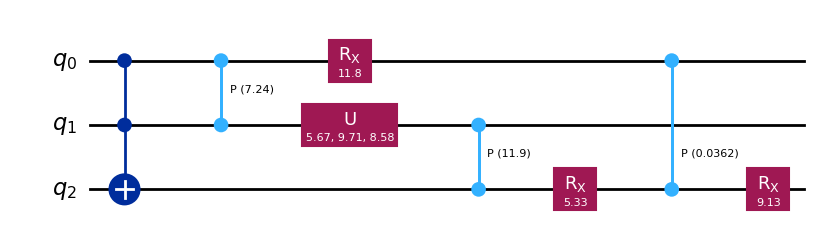

tensor([[-2,  4,  1,  0,  0,  0,  4,  0],
        [-2,  4,  0,  3,  4,  0,  0,  0],
        [ 2,  0,  0,  0,  4,  1,  4,  1]], dtype=torch.int32)

tensor([[ 0.0000,  0.1530,  0.8770, -0.0982,  0.8894, -0.1517, -0.9942,  0.4529],
        [ 0.0000,  0.0000,  0.0000,  0.5461,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.3656,  0.0000,  0.0000,  0.0000,  0.0000]])

tensor([[[-0.5160,  0.0000,  0.1092,  0.0922,  0.0000, -0.2913, -0.1705, -0.0078],
         [ 0.0059, -0.5158,  0.0487,  0.0356, -0.2911, -0.0280,  0.0643,  0.1626],
         [-0.1575,  0.0191, -0.4388, -0.2793,  0.0899, -0.0853,  0.6793,  0.0832],
         [ 0.0209, -0.1561, -0.1054,  0.1762, -0.0866,  0.0817, -0.1028, -0.4679],
         [ 0.0000, -0.2913, -0.1705, -0.0078, -0.5160,  0.0000,  0.1092,  0.0922],
         [-0.2913,  0.0022,  0.0614,  0.1631,  0.0017, -0.5160,  0.0496,  0.0260],
         [-0.0652, -0.0889,  0.3769, -0.0596, -0.1511, -0.0264, -0.1630, -0.2675],
         [-0.0890, -0.0645, -0.2472, -0.4959, -0.0259, -0.1516, -0.1986, -0.2816]],

        [[ 0.0000, -0.2100, -0.1229,  0.0109,  0.7160,  0.0000, -0.1515,  0.0664],
         [-0.2098, -0.0145,  0.0458, -0.2253, -0.0114,  0.7155, -0.0669,  0.0238],
         [-0.0470, -0.0641,  0.2716,  0.0827,  0.2096,  0.0366,  0.2261, -0.1928],
         [-0.0635, -0.0514, -0.1815,  0.6940,  0.0332,  0.2130,  0.2726, -0.2176],
  

In [10]:
qc, condition, qc_tensor, params_tensor = get_rnd_encoded_circuit(backend=simulator.backend, 
                                                                  tokenizer=tokenizer,
                                                                  condition=CircuitConditionType.UNITARY,       
                                                                  gate_pool=tokenizer.vocabulary,           
                                                                  num_of_qubits=3, 
                                                                  min_gates=4, 
                                                                  max_gates=8,
                                                                  rng=np.random.default_rng())
display(qc.draw("mpl"), qc_tensor, params_tensor, condition)

In [11]:
tensors, ys, Us, params = get_rnd_encoded_circuits(backend=simulator.backend, 
                                                   tokenizer=tokenizer,
                                                   condition=CircuitConditionType.UNITARY,
                                                   samples=128,          
                                                   num_of_qubits=4, 
                                                   min_gates=4, 
                                                   max_gates=16,
                                                   min_sub_gate_pool_cnt=2)
display(tensors[0], ys[0], params[0], Us.shape)

  0%|          | 0/128 [00:00<?, ?it/s]

[INFO]: Generated unique circuits: 125.
[INFO]: No max_num_params provided, infered p_max_para=3, p_min_value=tensor(-0.9998) and p_max_value=tensor(0.9996).


tensor([[-2, -2,  4,  2,  0,  4,  2, -2,  0,  0,  0,  4,  0,  0,  0,  0],
        [ 0, -2,  0,  0,  2,  0, -2,  2,  0,  2,  0,  0, -2,  0,  0,  0],
        [ 2,  2,  4, -2, -2,  4, -2, -2,  4, -2,  4,  4,  2,  0,  0,  0],
        [-2,  0,  0, -2, -2,  0,  0,  0,  4, -2,  4,  0, -2,  0,  0,  0]], dtype=torch.int32)

np.str_("Compile using: ['ccx', 'cp']")

tensor([[ 0.0000,  0.0000,  0.9185,  0.0000,  0.0000, -0.0226,  0.0000,  0.0000, -0.1110,  0.0000, -0.8066, -0.6071,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

torch.Size([125, 2, 16, 16])

In [12]:
ys[:5]

array(["Compile using: ['ccx', 'cp']", "Compile using: ['ccx', 'u']", "Compile using: ['ccx', 'u', 'cp']", "Compile using: ['rx', 'ccx', 'u', 'cp']", "Compile using: ['ccx', 'cp']"], dtype='<U39')

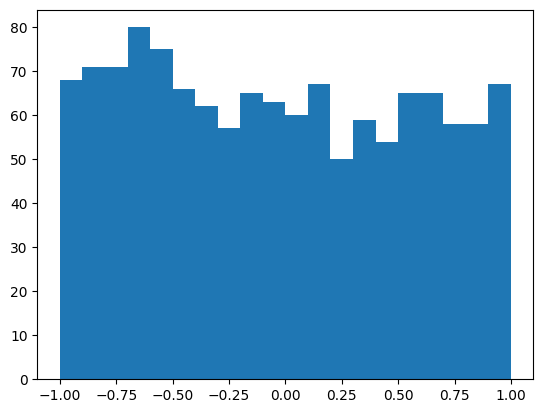

In [13]:
data = params.flatten()
ind  = data.nonzero(as_tuple=True)

plt.hist(data[ind], bins=20)
plt.show()

In [14]:
def test_unitary(tensor, param, should_U, rtol, atol):
    instructions = tokenizer.decode(tensor, param)
    qc   = simulator.genqc_to_backend(instructions)
    is_U = simulator.backend.get_unitary(qc)
    is_U = torch.stack([torch.from_numpy(np.real(is_U)), torch.from_numpy(np.imag(is_U))])
    
    assert torch.allclose(is_U, should_U, rtol=rtol, atol=atol)

In [15]:
for tensor, param, should_U in tqdm(zip(tensors, params, Us), total=tensors.shape[0]):
    test_unitary(tensor, param, should_U, rtol=1e-03, atol=1e-05)

  0%|          | 0/125 [00:00<?, ?it/s]

### Generate Dataset

In [16]:
tensors, ys, Us, params = generate_circuit_dataset(backend=simulator.backend, 
                                                   tokenizer=tokenizer,
                                                   condition=CircuitConditionType.UNITARY,
                                                   total_samples=512,
                                                   n_jobs=2,
                                                   num_of_qubits=3, 
                                                   min_gates=4, 
                                                   max_gates=16,
                                                   unitary_dtype=torch.float64,
                                                   min_sub_gate_pool_cnt=2)
display(Us.dtype, Us.shape)

[INFO]: Generated 498 valid circuits.
[INFO]: After filtering unique circuits: 494.


torch.float64

torch.Size([494, 2, 8, 8])

In [17]:
for tensor, param, should_U in tqdm(zip(tensors, params, Us), total=tensors.shape[0]):
    test_unitary(tensor, param, should_U, rtol=1e-03, atol=1e-05)

  0%|          | 0/494 [00:00<?, ?it/s]

# Export -

In [18]:
#| hide
import nbdev; nbdev.nbdev_export()